# Denoising SWOT data with a first order penalization filter 
* L. Gómez Navarro, E. Cosme, J. Le Sommer
* Started on 31 March 2017, last update on 20th February 2018

## Objective

xxx

## Input and output data

SWOT data here comes in the form of a NetCDF files from the SWOT ocean simulator. In this case 1km grid resolution BOX selected dataset is used.  It can be downloaded here:

The file can be downloaded here: 

xxxxxxxx

The output is xxx


## Related links

* https://github.com/SWOTsimulator

# Filtering Method description 
##### (Image denoising, N. Papadakis, March 2017)

### 1. Tikhonov regularization
We consider a noisy image $h_{obs}$ that we want to restore. We assume that the image $h_{obs}$ corresponds to a clean “ground truth” image $h_0$ that has been perturbed by an additional white Gaussian noise $ε$ so that: $h_{obs} = h_0 + ε$. To do so, one can consider the Tikhonov regularization of the gradient of the image and try to minimize the functional:
<br>
<br>
$$ J(h) = \frac{1}{2} \Vert h - h_{obs} \Vert ^2 + \frac{\lambda}{2} \Vert \nabla h \Vert ^2 $$
<br>
<br>
To optimize this convex problem, a simple gradient descent algorithm can be performed.
We have:
<br>
<br>
$$ \langle \nabla J(h),dh \rangle = \lim_{\epsilon\to0} \frac{J (h + \epsilon dh) - J(h)}{\epsilon} $$


### 2. Adaptation to SSH denoising
Let h denote a SSH map. From geostrophic balance one can assume that $v ∝ ∇^⊥ h$, where $v$ is the surface velocity. In this case, one has $ξ ∝ ∆h$, where $ξ$ is the relative vorticity, that is assumed spatially smooth. In the previous model, by regularizing the gradient of $h$, we are looking for a solution where $||∇h||$ is small, i.e. where the norm of the velocity field is small. This may be a bad regularization model.
Hence, a physically sound model to restore a noisy SSH map $h_{obs}$ could be to regularize the gradient of the vorticity, i.e. the gradients of the laplacian of the image:

<br>
$$ J(h) = \frac{1}{2}||h − h_{obs}||^2  +  \frac{λ}{2}||∇∆h||^2 $$
<br>
This problem can still be solved with a gradient descent algorithm that now reads:

<br>
$$h^{k+1} = h^k + τ(h_{obs} − h^k + λ∆∆∆h^k)$$
<br>
, and $τ$ should be taken as: $τ < 1/(1 + 512λ)$ to ensure the convergence of the algorithm.


# Loading the necesssary modules:

In [1]:
import glob
from netCDF4 import Dataset
import xarray as xr

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap

from shutil import copyfile
import os

%pylab inline

from scipy import ndimage

Populating the interactive namespace from numpy and matplotlib


# Defining the necessary functions:

In [2]:
def gradx(I): 
    """
    Calculates the gradient in the x-direction of an image I and gives as output M.
    In order to keep the size of the initial image the last row is left as 0s.
    """
    
    m, n = I.shape
    M = np.zeros([m,n])

    M[0:-1,:] = np.subtract(I[1::,:], I[0:-1,:])
    return M

def grady(I): 
    """
    Calculates the gradient in the y-direction of an image I and gives as output M.
    In order to keep the size of the initial image the last column is left as 0s.
    """
    
    m, n = I.shape
    M = np.zeros([m,n])
    M[:,0:-1] =  np.subtract(I[:,1::], I[:,0:-1])
    return M


In [3]:
def div(px, py): 
    """
    Calculates the divergence of a vector (px, py) and gives M as ouput
    ; where px and py have the some size and are the gradient in x and y respectively 
    of a variable p.
    The x component of M (Mx) first row is = to the first row of px.
    The x component of M (Mx) last row is = to - the before last row of px. (last one = 0)
    The y component of M (My) first column is = to the first column of py.
    The y component of M (My) last column is = to - the before last column of py. (last one = 0)
    ??#(de sorte que div=-(grad)^*)
    """
    m, n = px.shape
    M = np.zeros([m,n])
    Mx = np.zeros([m,n])
    My = np.zeros([m,n])
 
    Mx[1:m-1, :] = px[1:m-1, :] - px[0:m-2, :]
    Mx[0, :] = px[0, :]
    Mx[m-1, :] = -px[m-2, :]

    My[:, 1:n-1] = py[:, 1:n-1] - py[:, 0:n-2]
    My[:, 0] = py[:,0]
    My[:, n-1] = -py[:, n-2]
     
    M = Mx + My;
    return M

def np_laplacian(u):
    """
    Calculates the laplacian of u using the divergence and gradient functions and gives 
    as output Ml.
    """
    Ml = div(gradx(u), grady(u));
    return Ml

def trilaplacian(u):
    u2 = np_laplacian(np_laplacian(np_laplacian(u)))
    
    return u2

In [4]:
def penalization_filter_LR(var, var_obs, lambd,
            regularization_model, iter_max=100): #, epsilon=0.00000001):
    #, mask_of_data=mask_gap
    '''
    Version of the milter in which left and right swaths filtered separately and so masked not used.
    -Input(s):
    --var = variable to be filtered
    Default = 
    Default = 
    --var_obs = orginal data without filling the masked values 
    --lambd = lambda: regularization parameter (the larger lambda, the more regular is the denoised image).  
    This parameter needs to be adapted to the regularization model. 
    --regularization_model = 0 if Tikhonov regularization (first order penalization, i.e. gradient penalization) 
    and 1 if third order penalization (regularization of vorticity)
    --iter_max = maximum number of iterations in case it takes very long to converge
    --epsilon = 
    -Output(s):
    --ima1 = filtered image
    --itern = number of iterations realized until convergence
    '''
    
    ima0 = var
    ima_obs = var_obs
    
    if regularization_model == 0:
        tau = 1./(8*lambd)
        operator = np_laplacian
    elif regularization_model == 1:
        tau=1./(512*lambd)
        operator = trilaplacian
    else:
        print "Undefined regularization model"
    
    itern = 1
    ima1 = ima0 + tau*((ima_obs - ima0) + lambd*operator(ima0))
    
    """
    norm_minus = np.nansum((ima1 - ima0)**2) + np.nansum((ima1 - ima0)**2)
    norm_ima0 = np.nansum((ima0)**2) + np.nansum((ima0)**2)
    conv_crit = norm_minus / norm_ima0
    """
    
    while (itern < iter_max): #(conv_crit > epsilon) & 
        ima0 = np.copy(ima1)
        itern = itern + 1
        ima1 = ima0 + tau*((ima_obs - ima0) + lambd*operator(ima0))
        """
        norm_minus = np.nansum((ima1 - ima0)**2) + np.nansum((ima1 - ima0)**2)
        norm_ima0 = np.nansum((ima0)**2) + np.nansum((ima0)**2)
        conv_crit = norm_minus / norm_ima0
        """    
    return ima1, itern


In [5]:
def separate_swaths(var, nhalfswath):
    """
    Separating into left and right swaths a particular variable, var, ignoring the nadir.
    - var: variable to separate
    Function(s) used in:
    - gradient_norm_method1
    - velocity_norm
    - var_on_ugrid
    - var_on_vgrid
    - var_on_fgrid
    - geostrophic_velocities_method1
    - geostrophic_velocities_method2
    - geostrophic_velocities_method3
    - rel_vorticity_method2
    - rel_vorticity_method3
    - rossby_nb_method2
    - rossby_nb_method3
    """

    ii, jj = var.shape

    if ii % 2 == 0:

        var_left = var[0:nhalfswath,:] #self.nhalfswath = ii/2 
        #--> only possible for SSH, if for vel, need not same nhalfswath when calculated via method 1
        var_right = var[nhalfswath::,:]

    else: # I assume it's because it includes nadir
        var_left = var[0:nhalfswath,:]
        var_right = var[nhalfswath+1::,:]
        
    return var_left, var_right

# using as var (pre-conditioning) lambda = 100 first order, i.e. test05

In [6]:
filename_precond = 'MED_1km_nogap_FMA13_swotFastPhase_BOX_filtered_test05_c*'
datadir_precond = '/Users/laura/Documents/data/SWOT_filtered/fast_sampling_test7/gaussian_filter//'
myfilesp = sorted(glob.glob(datadir_precond + filename_precond))

In [69]:
def SWOT_filter(myfile, myfilep, output_filename, lambd, regularization_model, plot, savefig):
        
    output_file = Dataset(output_filename, 'w', format='NETCDF4_CLASSIC')

    ##====================== Load SWOT data ========================

    nc = Dataset(myfile)
    lon = nc.variables['lon_box'][:]
    lat = nc.variables['lat_box'][:]
    SSH_obs = nc.variables['ADT_obs_box'][:]
    SSH_model = nc.variables['ADT_model_box'][:]
    x_ac = nc.variables['x_ac'][:]
    x_al = nc.variables['x_al'][:]

    nhalfswath = np.shape(lon)[1]/2
    
    lon = np.transpose(lon)
    lat = np.transpose(lat)
    SSH_model = np.transpose(SSH_model)
    SSH_obs = np.transpose(SSH_obs) 

    # 2. Check longitude in -180 : +180 format:
    if any(xlo < 0 for xlo in lon):
        lon[lon > 180] -= 360 

    # 3. Flipping the SWOT array if necessary: 
    # So that lon increases from left to right and lat from bottom to top 
    # (depends on if pass is ascending or descending)

    lon_dif = lon[1,0] - lon[0,0]
    lat_dif = lat[0,1] - lat[0,0]

    # Need to revise below , above already adapted for datasets oragnized as x,y instead of y,x
    if (lat_dif<0):
        print 'flipped variables created'
        ## Ascending pass (pass 22 for in the fast-sampling phase)        
        lon = np.flipud(lon)
        lat = np.flipud(lat)
        SSH_model = np.flipud(SSH_model)
        SSH_obs = np.flipud(SSH_obs)

    elif (lon_dif<0):
        print 'flipped variables created'
        ## Descending pass (pass 9 for in the fast-sampling phase)
        lon = np.fliplr(lon)
        lat = np.fliplr(lat)
        SSH_model = np.fliplr(SSH_model)
        SSH_obs = np.fliplr(SSH_obs)
    
    # Loading pre-conditioning:
    nc = Dataset(myfilep)
    SSH_model_precond = nc.variables['SSH_model_filtered'][:]
    SSH_obs_precond = nc.variables['SSH_obs_filtered'][:]
    
    SSH_model_precond = SSH_model_precond.T
    SSH_obs_precond = SSH_obs_precond.T
    
    ##=========== Separate into left and right swath ===============
    SSH_obs_left, SSH_obs_right = separate_swaths(SSH_obs, nhalfswath)
    xx_left, yy_left = np.where(~SSH_obs_left.mask)
    xx_right, yy_right = np.where(~SSH_obs_right.mask)

    left_gap_indices = np.unique(xx_left)
    right_gap_indices = np.unique(xx_right)
    
    # (not including the gap for obs, that's why -5 and +6 used)
    SSH_obs_left_nogap = SSH_obs_left[left_gap_indices,:]
    SSH_obs_right_nogap = SSH_obs_right[right_gap_indices,:]
    
    SSH_model_left, SSH_model_right = separate_swaths(SSH_model, nhalfswath)
    SSH_model_left_nogap = SSH_model_left[left_gap_indices,:]
    SSH_model_right_nogap = SSH_model_right[right_gap_indices,:]
    
    gpx, gpy = np.where(SSH_obs.mask)
    gap_indices = unique(gpx)
    
    gpx_n, gpy_n = np.where(~SSH_obs.mask)
    gap_indices_n = unique(gpx_n)
    
    SSH_model_precond_left = SSH_model_precond[left_gap_indices,:]
    SSH_model_precond_right = SSH_model_precond[right_gap_indices,:]
    SSH_obs_precond_left = SSH_obs_precond[left_gap_indices,:]
    SSH_obs_precond_right = SSH_obs_precond[right_gap_indices,:]
    
    plt.figure()
    plt.pcolor(SSH_model);plt.colorbar()
    plt.figure()
    plt.pcolor(SSH_model_precond);plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.subplot(121)
    plt.pcolor(SSH_model_right_nogap);plt.colorbar()
    plt.subplot(122)
    plt.pcolor(SSH_model_precond_left);plt.colorbar()
    plt.show()
    
    ##======================= Applying the filter ====================
    print 'Filtering SSH_model'
    filt_SSH_model_left, itermL = penalization_filter_LR(var=SSH_model_precond_left, var_obs=SSH_model_left_nogap, lambd=lambd, regularization_model=1)
    filt_SSH_model_right, itermR = penalization_filter_LR(var=SSH_model_precond_right, var_obs=SSH_model_right_nogap, lambd=lambd, regularization_model=1)
    print 'Filtering SSH_obs'
    filt_SSH_obs_left, iteroL = penalization_filter_LR(var=SSH_obs_precond_left, var_obs=SSH_obs_left_nogap, lambd=lambd, regularization_model=1)
    filt_SSH_obs_right, iteroR = penalization_filter_LR(var=SSH_obs_precond_right, var_obs=SSH_obs_right_nogap, lambd=lambd, regularization_model=1)

    ##=================== Joining SSH_obs ==========================
    # (Alternative to concatenating and so conserving gap)
    """
    filt_SSH_model = np.ma.empty_like(SSH_obs)
    filt_SSH_model[0:gap_indices.min(),:] = filt_SSH_model_left
    filt_SSH_model[gap_indices.max()+1::,:] = filt_SSH_model_right
    filt_SSH_obs = np.ma.empty_like(SSH_obs)
    filt_SSH_obs[0:gap_indices.min(),:] = filt_SSH_obs_left
    filt_SSH_obs[gap_indices.max()+1::,:] = filt_SSH_obs_right
    """
    filt_SSH_model = np.concatenate((filt_SSH_model_left,filt_SSH_model_right),axis=0)
    filt_SSH_obs = np.concatenate((filt_SSH_obs_left,filt_SSH_obs_right),axis=0)
    
    iter_maxm = [itermL, itermR]
    iter_maxo = [iteroL, iteroR]
    ##=================== Writing output NetCDF fil e=================
    #The output file has been created earlier (see above). Here we check whether the   variables we want to save already exist in this file, or not. If not, they are created in the NetCDF file. The filtered SSH fields are then saved in these variables.

    # Create dimensions
    x_al2 = output_file.createDimension('x_al2', len(x_al))
    x_ac2 = output_file.createDimension('x_ac2', len(gap_indices_n))

    # Creates variable:
    x_al3 = output_file.createVariable('x_al', np.int32, ('x_al2',)) 
    x_ac3 = output_file.createVariable('x_ac', np.int32, ('x_ac2',)) 
        
    x_al3[:] = x_al
    x_ac3[:] = x_ac[gap_indices_n]
    
    lons = output_file.createVariable('lon', np.float32, ('x_ac2', 'x_al2'))
    lats = output_file.createVariable('lat', np.float32, ('x_ac2', 'x_al2'))
    SSH_models = output_file.createVariable('SSH_model', np.float32, ('x_ac2', 'x_al2'))
    SSH_obss = output_file.createVariable('SSH_obs', np.float32, ('x_ac2', 'x_al2'))
    SSH_model_filtered = output_file.createVariable('SSH_model_filtered', np.float32, ('x_ac2', 'x_al2'))
    SSH_obs_filtered = output_file.createVariable('SSH_obs_filtered', np.float32, ('x_ac2', 'x_al2'))
    # Define units:
    SSH_model_filtered.units = "m"
    SSH_obs_filtered.units = "m"
    # Define long_name:
    SSH_model_filtered.long_name = "SSH interpolated from model filtered using a third order penalization filter"
    SSH_obs_filtered.long_name = "Observed SSH (SSH_model+errors) filtered using a third order penalization filter" 
    # Define filter parameter(s) as attribute:
    SSH_model_filtered.Lambda = lambd
    SSH_obs_filtered.Lambda = lambd
    SSH_model_filtered.iter_max = iter_maxm
    SSH_obs_filtered.iter_max = iter_maxo
    
    lons[:,:] = lon[gap_indices_n,:]
    lats[:,:] = lat[gap_indices_n,:]
    SSH_models[:,:] = SSH_model[gap_indices_n,:]
    SSH_obss[:,:] = SSH_obs[gap_indices_n,:]
    SSH_model_filtered[:,:] = filt_SSH_model
    SSH_obs_filtered[:,:] = filt_SSH_obs
    
    output_file.close()

    return filt_SSH_model, filt_SSH_obs 


##### To obtain the basemap package:
conda install basemap
(if not use: conda install -c conda-forge basemap-data-hires)


## Input and output directories and files:
Define input and output directory and filename. If the output file does not exist yet, it is created. Note that only one SWOT pass is processed here (myfile).

In [70]:
directory = '/Users/laura/PhD_private/data/SWOT_box_selections/'
myfiles = sorted(glob.glob(directory + '*FMA13*c*.nc'))
output_directory = '/Users/laura/Documents/data/SWOT_filtered/fast_sampling_test7/tikhonov_filter_reg1_OSM18_precond_test3/'

## Filtering using a Tikhonov regularization (first order penalization) filter:

For each (left and right) swath, the filter is applied to the simulated SWOT data (including noise) and the noise-free data.

In [71]:
lambds = [20., 40., 60., 80., 100., 150., 200., 250.]  #adapt this parameter w.r.t to the regularization model

# Filter and save:

-------------------------------------------------------
test_Conv_Crit_01
-------------------------------------------------------
Input file:/Users/laura/PhD_private/data/SWOT_box_selections/MED_1km_nogap_FMA13_swotFastPhase_BOX_c01_p009.nc
Output file: /Users/laura/Documents/data/SWOT_filtered/fast_sampling_test7/tikhonov_filter_reg1_OSM18_precond_test3/MED_1km_nogap_FMA13_swotFastPhase_BOX_filtered_test_Conv_Crit_01_c01_p009.nc
Precond file: /Users/laura/Documents/data/SWOT_filtered/fast_sampling_test7/gaussian_filter/MED_1km_nogap_FMA13_swotFastPhase_BOX_filtered_test05_c01_p009.nc


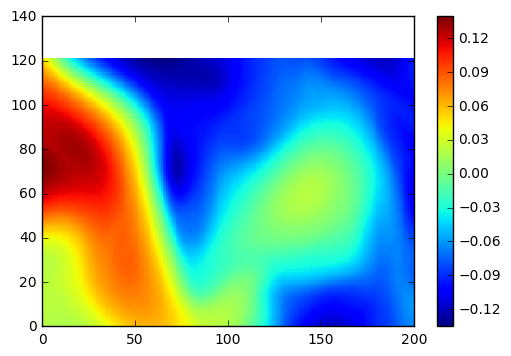

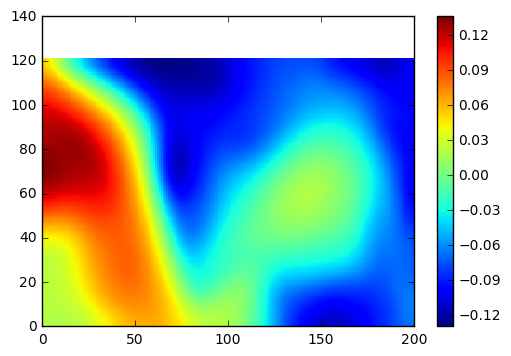

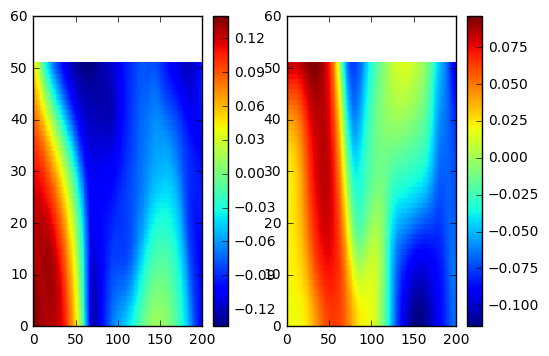

NameError: name 'jfskkcanj' is not defined

In [72]:
testnumber = 0 
for ff in xrange(0, len(lambds)):
    lambd = lambds[ff]
    testnumber = testnumber + 1
    testname = 'test_Conv_Crit_' + str(testnumber).zfill(2)
    print '-------------------------------------------------------'
    print testname

    for ii, myfile in enumerate(myfiles):
        print '-------------------------------------------------------'
        print 'Input file:' + myfile
        filtered_filename = myfile[-49:-12] + '_filtered_' + testname + myfile[-12:-3] + '.nc'
        
        output_filename = output_directory + filtered_filename
        print 'Output file: ' + output_filename
        
        myfilep = myfilesp[ii]
        print 'Precond file: ' + myfilep
        filt_SSH_model, filt_SSH_obs, xxx = SWOT_filter(myfile, myfilep, output_filename, lambd, regularization_model=1, plot='no', savefig='no')
        jfskkcanj # to see result after one iteraion before continuing

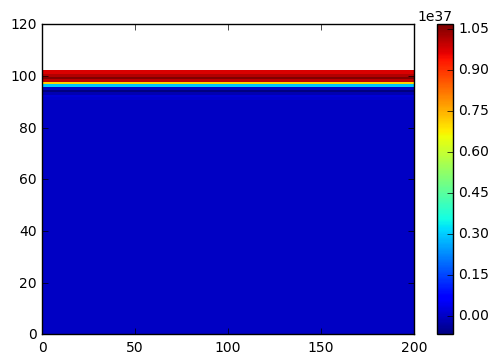

In [28]:
plt.pcolor(filt_SSH_obs);plt.colorbar()